In [142]:
from __future__ import unicode_literals, print_function
import io
import glob
import os
import string 
import unicodedata
import random 
import time 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

random.seed(0)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
all_letters = string.ascii_letters+" .,;'"
n_letters = len(all_letters)

In [44]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def read_file(file):
    f = open(file, encoding='utf-8')
    lines = f.readlines()
    return [unicode_to_ascii(i) for i in lines]
                 
data = {}
all_cats = []

files = glob.glob('data/nlp_data/ndata/names/*.txt')
for file in files:
    cat = file.split('/')[-1][:-4]
    lines = read_file(file)
    data[cat] = lines
    all_cats.append(cat)

n_cats = len(all_cats)

In [55]:
sum([len(data[i]) for i in data])

20074

In [7]:
letter_to_idx = {j: i for i,j in enumerate(all_letters)}

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_idx[letter]] = 1
    return tensor

print(line_to_tensor('Adam').size())
print(line_to_tensor("Adam"))

torch.Size([4, 1, 57])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

In [131]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), 1).to(device)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

def get_model(n_hidden = 128):
    rnn = RNN(n_letters, n_hidden, n_cats)
    rnn.to(device)
    return rnn

In [129]:
sample = line_to_tensor("Adam")
print(sample.size())
letter = sample[0]
print(letter.size())
hidden = torch.zeros(1, n_hidden)

out, next_hidden = rnn(letter, hidden)
print(out)

torch.Size([4, 1, 57])
torch.Size([1, 57])
tensor([[-2.8496, -2.8456, -2.9160, -2.7991, -2.9318, -2.8080, -2.9184, -2.8699,
         -2.9236, -2.8663, -2.9177, -2.8635, -2.9112, -2.9037, -2.8667, -2.9454,
         -2.9864, -2.9239]], grad_fn=<LogSoftmaxBackward>)


In [35]:
def cat_from_output(output):
    _, top = torch.max(output, dim = 1)
    idx = top.item()
    return all_cats[idx], idx

In [36]:
print(cat_from_output(out))

('Italian', 11)


In [130]:
def get_train_data():
    X, y = [], []
    for category in data:
        for line in data[category]:
            label = all_cats.index(category)
            inputs = line_to_tensor(line)
            X.append(inputs)
            y.append(label)
    return X, y

In [87]:
X, y = get_train_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify = y, test_size = 0.1)

In [89]:
for y in [y_train, y_test]:
    for i, label in enumerate(y):
        y[i] = torch.tensor([label], dtype = torch.long)

[tensor([17]), tensor([17]), tensor([3])] [tensor([17]), tensor([17]), tensor([17])]


In [112]:
print(y_train[0])

tensor([17])


In [119]:
train_data = list(zip(X_train, y_train))
test_data = list(zip(X_test, y_test))

In [133]:
def train(model, optimizer, epochs):
    start = time.time()
    
    train_losses = []
    train_acc = []
    eval_losses = []
    eval_acc = []
    
    for epoch in range(epochs):
        print(f'Epoch - {epoch+1}/{epochs}')
        print('-'*20)
        
        for phase in ['train', 'eval']:
            running_loss = 0.0
            running_correct = 0
            
            e_start = time.time()
            if phase == 'train':
                for data in train_data:
                    inputs, labels = data
                    labels =  labels.to(device)
                    hidden = model.init_hidden()
                    
                    optimizer.zero_grad()

                    for i in range(inputs.size()[0]):
                        letter = inputs[i][0].unsqueeze(0)
                        output, hidden = model(letter, hidden)

                    _, pred = torch.max(output, dim = 1)
                    loss = criterion(output, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    running_correct += torch.sum(pred == labels.data)
                
                epoch_loss = running_loss/len(X_train)
                acc = (running_correct.double()/len(X_train))*100
                
                train_losses.append(epoch_loss)
                train_acc.append(acc)
            
            else:
                with torch.no_grad():
                    for data in test_data:
                        inputs, labels = data
                        labels =  labels.to(device)
                        hidden = model.init_hidden()

                        optimizer.zero_grad()

                        for i in range(inputs.size()[0]):
                            letter = inputs[i][0].unsqueeze(0)
                            output, hidden = model(letter, hidden)

                        _, pred = torch.max(output, dim = 1)
                        loss = criterion(output, labels)

                        running_loss += loss.item()
                        running_correct += torch.sum(pred == labels.data)                

                epoch_loss = running_loss/len(X_test)
                acc = (running_correct.double()/len(X_test))*100
                
                eval_losses.append(epoch_loss)
                eval_acc.append(acc)
                
            e_end = time.time()-e_start
            print(f'{phase} : loss - {epoch_loss:3.2f} acc - {acc:3.2f} , Time - {e_end:.2f}')
        
    end = time.time() - start
    print(f'Training time - {end:.2f}')
    return model, [train_losses, train_acc, eval_losses, eval_acc]

In [140]:
rnn = get_model()
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters(), lr = .001)
print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)


In [141]:
trained_model, metrics = train(rnn, optimizer, 5)

Epoch - 1/5
--------------------
train : loss - 1.17 acc - 65.81 , Time - 64.55
eval : loss - 0.96 acc - 70.27 , Time - 1.51
Epoch - 2/5
--------------------
train : loss - 0.93 acc - 71.36 , Time - 60.76
eval : loss - 0.89 acc - 71.51 , Time - 1.38
Epoch - 3/5
--------------------
train : loss - 0.88 acc - 72.48 , Time - 57.92
eval : loss - 0.87 acc - 72.21 , Time - 1.46
Epoch - 4/5
--------------------
train : loss - 0.85 acc - 73.29 , Time - 64.63
eval : loss - 0.87 acc - 73.06 , Time - 1.48
Epoch - 5/5
--------------------
train : loss - 0.83 acc - 73.86 , Time - 43.86
eval : loss - 0.83 acc - 74.65 , Time - 1.37
Training time - 298.93


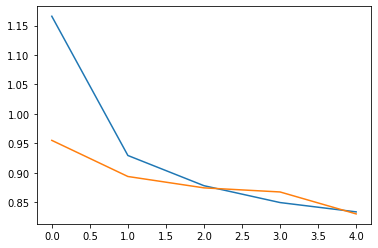

In [154]:
fig, ax = plt.subplots()
ax.plot(metrics[0])
ax.plot(metrics[2])